# Example: Modelling an enzymatic reaction with Michaelis-Menten kinetics

In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import pandas
import scipy
from matplotlib import pyplot
from IPython.display import display

import calibr8
import murefi

## Overview: Fitting with `calibr8` and `murefi`
Let's assume that you want to model the [Michaelis-Menten kinetics](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics) of an enzymatic assay for estimating the enzymatic activity ($v_{max}$). For this toy example, let's assume that we measured the reaction product $P$ by absorbance at a wavelength of 570 nm.

For the analysis, you need...

1. [`calibr8` calibration model](htps://calibr8.readthedocs.io) of the $P$ vs. $A_{570}$ correlation
2. Correlation data for $P\ [mmol/L]$ vs. measurement readout $A_{570}\ [a.u.]$
3. `murefi` ODE model of Michaelis-Menten kinetics
4. Kinetic data of product accumulation (vectors of $t$ and $A_{570}$)

⚠ About 75 % of the code in this example is for preparing fake data. ⚠

## Preparing Data & Models
### 1. & 2. Calibration model of product concentration
Because this part is shown in examples for `calibr8`, everything is condensed into one cell.

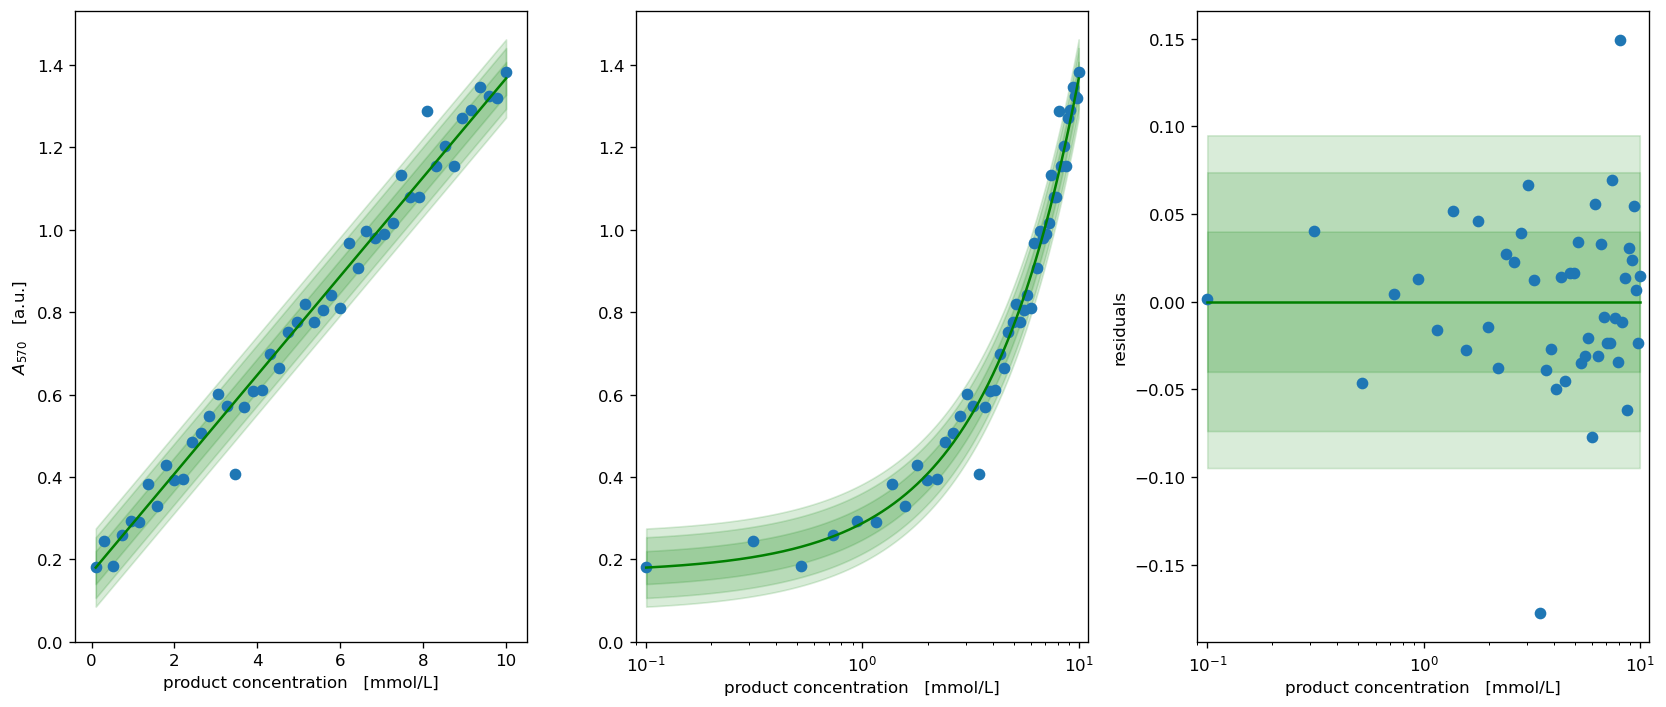

In [2]:
class ProductAssayModel(calibr8.BasePolynomialModelT):
    def __init__(self):
        super().__init__(
            independent_key='P',
            dependent_key='A570',
            mu_degree=1,
            scale_degree=0,
        )
        
def observe_with_true_parameters(x):
    return scipy.stats.t.rvs(loc=0.17 + 0.12 * x, scale=0.03, df=3)

# generate fake calibration data with a linear relationship
numpy.random.seed(202103)
N = 48
X = numpy.linspace(0.1, 10, N)
Y = observe_with_true_parameters(X)

cm_product = ProductAssayModel()
theta_fit, _ = calibr8.fit_scipy(
    cm_product,
    independent=X, dependent=Y,
    theta_guess=[0, 0.2, 0.05, 5],
    theta_bounds=[(-2, 2), (0.001, 0.5), (0.001, 0.5), (1, 10)]
)
fig, axs = calibr8.plot_model(cm_product);
for ax in axs:
    ax.set_xlabel('product concentration   [mmol/L]')
axs[0].set_ylabel('$A_{570}$   [a.u.]')
axs[1].set_ylabel("")
axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
fig.tight_layout()
pyplot.show()

### 3. ODE Model of enzyme kinetics
To describe the kinetics of our enzyme of interest, we'll use the ODEs of the Michaelis-Menten kinetics:

$$\frac{dP}{dt}= v_{max} \cdot \frac{S}{K_S+S}$$

$$\frac{dS}{dt}=-\frac{dP}{dt}$$

For our data analysis we'll have to implement it with `murefi`:

In [3]:
class MichaelisMentenModel(murefi.BaseODEModel):
    def __init__(self):
        self.guesses = dict(S_0=5, P_0=0, v_max=0.1, K_S=1)
        self.bounds = dict(
            S_0=(1, 20),
            P_0=(0, 10),
            v_max=(0.0001, 5),
            K_S=(0.01, 10),
        )
        super().__init__(
            independent_keys=['S', 'P'],
            parameter_names=["S_0", "P_0", "v_max", "K_S"],
        )

    def dydt(self, y, t, theta):
        S, P = y
        v_max, K_S = theta
        
        dPdt = v_max * S / (K_S + S)    
        return [
            -dPdt,
            dPdt,
        ]
    
model = MichaelisMentenModel()

### 4. Data of enzymatic reaction
Because this is an example notebook, we'll have to fake our data...
This can be done by
1. simulating a trajectory with our `model` and
2. using the `observe_with_true_parameters` function to make noisy observations of the product concentrations with the ground truth $A_{570}$/$P$  relationship

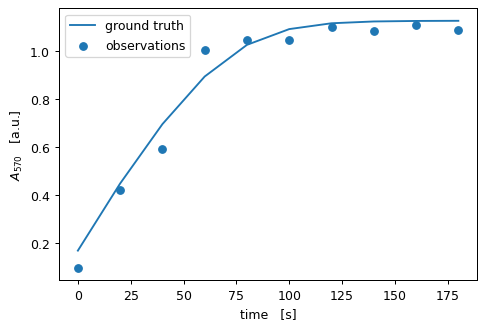

In [5]:
# generate ground truth data at 10 time points
theta_true = (8, 0, 0.16, 2.5)
rep_groundtruth = model.predict_replicate(
    # S_0, P_0, v_max, K_S
    parameters=theta_true,
    template=murefi.Replicate.make_template(tmin=0, tmax=180, independent_keys='SP', rid='A01', N=10)
)

# use error model to make noisy observations of the ground truth
rep_observed = murefi.Replicate(rid='A01')
rep_observed['A570'] = murefi.Timeseries(
    t=rep_groundtruth['P'].t,
    y=observe_with_true_parameters(rep_groundtruth['P'].y),
    independent_key='P',
    dependent_key='A570'
)

# pack generated data into Dataset
dataset = murefi.Dataset()
dataset[rep_observed.rid] = rep_observed


fig, ax = pyplot.subplots(dpi=90)
ax.scatter(rep_observed['A570'].t, rep_observed['A570'].y, label='observations')
# use error model to project groundtruth onto dependent variable axis
ax.plot(rep_observed['A570'].t, cm_product.predict_dependent(rep_groundtruth["P"].y)[0], label='ground truth')
ax.set(xlabel='time   [s]', ylabel='$A_{570}$   [a.u.]')
ax.legend()
pyplot.show()

## Estimation of model parameters
With `murefi`, one can fit an entire dataset while sharing parameters across replicates. The sharing of parameters is achieved via a data structure called `ParameterMapping`.

The `ParameterMapping` is created from a table that maps each replicate in the dataset to a vector of parameters. Parameters that shall remain fixed are set as `float` while flexible parameters are identified by a `str`.

Here, we have just one replicate, so the `ParameterMapping` remains simple:

In [6]:
df_mapping = pandas.DataFrame(columns='rid,S_0,P_0,v_max,K_S'.split(',')).set_index('rid')
# we'll fix S_0=8.0 and fit only the remaining parameters
df_mapping.loc['A01'] = (8.0, 'P_0', 'v_max', 'K_S')

# create the ParameterMapping object
pm = murefi.ParameterMapping(
    df_mapping,
    guesses=model.guesses,      # fed as dict where the key is the name of the parameter
    bounds=model.bounds         # same as guesses
)
display(pm.as_dataframe())
display(pm)

,S_0,P_0,v_max,K_S
rid,,,,
A01,8.0,P_0,v_max,K_S


ParameterMapping(1 replicates, 4 inputs, 3 free parameters)

The `ParameterMapping` object `pm` can now be used to create an optimization objective for a `Dataset` & given a `ParameterMapping`.
To connect model predictions with data, it requires a list of `calibr8.CalibrationModel`.

Without a calibration model, the data will not contribute to the fit!

In [7]:
obj = murefi.objectives.for_dataset(
    dataset,
    model,
    pm,
    # no need for a substrate calibration model, because there's no data
    calibration_models=[cm_product]
)

# The objective function can be evaluated at the initial guess to see if everything works as expected:
print(f'Objective at initial guess: {obj(pm.guesses)}')

Objective at initial guess: -9.793625758398255


Now the model can be fitted with `scipy.optimize.minimize`.

If fitting does not work, check the following most common problems:
- objective could evaluate to `nan` (check this with `objective(pm.guesses)`)
- initial guesses might be too unrealistic
- bounds may be too open (invalid predictions, hard to find the optimum)
- bounds may be too restrictive (fit hits the bound)
- bounds may be unrealistic (e.g. not preventing negative $K_S$)
- calibration models using the $Normal$ distribution often cause numerical problems

In [8]:
model_fit = scipy.optimize.minimize(
    obj,
    pm.guesses,
    bounds=pm.bounds
)
model_fit

      fun: -13.103571329566996
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.38555834e-05,  1.84721536e+01,  4.38937775e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 23
     njev: 42
   status: 0
  success: True
        x: array([1.54038219, 0.        , 0.13220258])

## Visualizing the optimization result
To visualize the result, we'll use the `ParameterMapping.repmap` method to transform the global parameter vector (3 entries) into a parameter vector for our model (4 entries).
This is necessary because the global one has a different order and is missing parameters that were fixed.

Then, we can make a high-density prediction using our model:

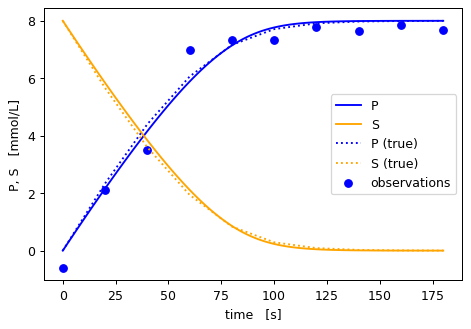

In [9]:
# first make a high-density prediction
rep_fit = model.predict_replicate(
    parameters=pm.repmap(model_fit.x)['A01'],
    template=murefi.Replicate.make_template(tmin=0, tmax=180, independent_keys='SP')
)

fig, ax = pyplot.subplots(dpi=90)
colors = dict(P='blue', S='orange')

# plot data, transformed via the error model into the independent unit
t_obs = rep_observed['A570'].t
y_obs = cm_product.predict_independent(rep_observed['A570'].y)
ax.scatter(t_obs, y_obs, label='observations',color=colors['P'])

# plot all timeseries of the fit
for ykey, ts in reversed(rep_fit.items()):
    ax.plot(ts.t, ts.y, label=ykey, color=colors[ykey])
    
# plot all timeseries of the groundtruth for comparison
for ykey, ts in reversed(rep_groundtruth.items()):
    ax.plot(ts.t, ts.y, label=ykey + ' (true)', linestyle=':', color=colors[ykey])

ax.set_xlabel('time   [s]')
ax.set_ylabel('P, S   [mmol/L]')
ax.legend()
pyplot.show()

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Mar 29 2021

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.19.0

murefi    : 5.0.0
scipy     : 1.5.2
matplotlib: 3.3.2
numpy     : 1.19.2
pandas    : 1.2.1
calibr8   : 6.0.0

Watermark: 2.2.0

